# E: State stabilization with SNAP gates and displacement gates

The use of feedback GRAPE applied to the Jaynes-
Cummings scenario allows us to discover strategies
extending the lifetime of a range of quantum states. How-
ever, for more complex quantum states such as kitten
states, the infidelity becomes significant after just a few
dissipative evolution steps in spite of the feedback [cf.
Fig. 6(c)]. This raises the question of whether the limited
quality of the stabilization is to be attributed to a failure
of our feedback-GRAPE learning algorithm to properly
explore the control-parameter landscape or, rather, to the
limited expressivity of the controls. With the goal of
addressing this question, we test our method on the state-
stabilization task using a more expressive control scheme.

In [1]:
# ruff: noqa
import os

#os.sys.path.append("../../../..")
os.sys.path.append("./../../feedback-grape")

In [2]:
# ruff: noqa
from feedback_grape.fgrape import optimize_pulse
from feedback_grape.utils.operators import cosm, sinm, identity
from feedback_grape.utils.states import coherent
import jax.numpy as jnp
import jax

jax.config.update("jax_enable_x64", True)

## Initialize states

In [3]:
from feedback_grape.utils.fidelity import ket2dm

N_cav = 30  # number of cavity modes
N_snap = 15

alpha = 2
psi_target = coherent(N_cav, alpha) + coherent(N_cav, -alpha)

# Normalize psi_target before constructing rho_target
psi_target = psi_target / jnp.linalg.norm(psi_target)

rho_target = ket2dm(psi_target)

In [4]:
# Parity Operator
from feedback_grape.utils.operators import create, destroy


def parity_operator(N_cav):
    return jax.scipy.linalg.expm(1j * jnp.pi * (create(N_cav) @ destroy(N_cav)))

In [5]:
# Confirm that the kitten2 state has an even parity
parity_op = parity_operator(N_cav)
parity_check = jnp.isclose(
    jnp.trace((parity_op @ rho_target) @ rho_target), 1.0
)
print("Parity check for the kitten2 state:", parity_check)
print("parity_check trace :", jnp.real(jnp.trace(parity_op @ rho_target)))

Parity check for the kitten2 state: True
parity_check trace : 1.0000000000000013


## Initialize the parameterized Gates

In [6]:
def displacement_gate(alphas):
    """Displacement operator for a coherent state."""
    alpha_re, alpha_im = alphas
    alpha = alpha_re + 1j * alpha_im
    gate = jax.scipy.linalg.expm(
        alpha * create(N_cav) - alpha.conj() * destroy(N_cav)
    )
    return gate


def displacement_gate_dag(alphas):
    """Displacement operator for a coherent state."""
    alpha_re, alpha_im = alphas
    alpha = alpha_re + 1j * alpha_im
    gate = (
        jax.scipy.linalg.expm(
            alpha * create(N_cav) - alpha.conj() * destroy(N_cav)
        )
        .conj()
        .T
    )
    return gate

In [7]:
def snap_gate(phase_list):
    diags = jnp.ones(shape=(N_cav - len(phase_list)))
    exponentiated = jnp.exp(1j * jnp.array(phase_list))
    diags = jnp.concatenate((exponentiated, diags))
    return jnp.diag(diags)

### povm_measure_operator (callable): <br>
    - It should take a measurement outcome and list of params as input
    - The measurement outcome options are either 1 or -1

In [8]:
from feedback_grape.utils.operators import create, destroy


def povm_measure_operator(measurement_outcome, params):
    """
    POVM for the measurement of the cavity state.
    returns Mm ( NOT the POVM element Em = Mm_dag @ Mm ), given measurement_outcome m, gamma and delta
    """
    gamma, delta = params
    cav_operator = gamma * create(N_cav) @ destroy(N_cav) + delta / 2 * identity(N_cav)
    angle = cav_operator
    meas_op = jnp.where(
        measurement_outcome == 1,
        cosm(angle),
        sinm(angle),
    )
    return meas_op

## Initialize RNN of choice

In [9]:
import flax.linen as nn


# You can do whatever you want inside so long as you maintaing the hidden_size and output size shapes
class RNN(nn.Module):
    hidden_size: int  # number of features in the hidden state
    output_size: int  # number of features in the output (inferred from the number of parameters) just provide those attributes to the class

    @nn.compact
    def __call__(self, measurement, hidden_state):

        if measurement.ndim == 1:
            measurement = measurement.reshape(1, -1)

        ###############
        ### Free to change whatever you want below as long as hidden layers have size self.hidden_size
        ### and output layer has size self.output_size
        ###############

        gru_cell = nn.GRUCell(
            features=self.hidden_size,
            gate_fn=nn.sigmoid,
            activation_fn=nn.tanh,
        )
        self.make_rng('dropout')

        new_hidden_state, _ = gru_cell(hidden_state, measurement)
        new_hidden_state = nn.Dropout(rate=0.1, deterministic=False)(
            new_hidden_state
        )
        # this returns the povm_params after linear regression through the hidden state which contains
        # the information of the previous time steps and this is optimized to output best povm_params
        # new_hidden_state = nn.Dense(features=self.hidden_size)(new_hidden_state)
        new_hidden_state = nn.Dense(
            features=self.hidden_size,
            kernel_init=nn.initializers.glorot_uniform(),
        )(new_hidden_state)
        new_hidden_state = nn.relu(new_hidden_state)
        new_hidden_state = nn.Dense(
            features=self.hidden_size,
            kernel_init=nn.initializers.glorot_uniform(),
        )(new_hidden_state)
        new_hidden_state = nn.relu(new_hidden_state)
        output = nn.Dense(
            features=self.output_size,
            kernel_init=nn.initializers.glorot_uniform(),
            bias_init=nn.initializers.constant(0.1),
        )(new_hidden_state)
        output = nn.relu(output)

        ###############
        ### Do not change the return statement
        ###############

        return output[0], new_hidden_state

### In this notebook, we decreased the convergence threshold and evaluate for num_time_steps = 2

In [10]:
# Note if tsave = jnp.linspace(0, 1, 1) = [0.0] then the decay is not applied ?
# because the first time step has the original non decayed state
from feedback_grape.fgrape import Decay, Gate

key = jax.random.PRNGKey(42)

# Answer: In documentation, clarify that the initial_params are the params up to the
# point where measurement occurs, compared with other modes where the initial_params
# are the initial params for the entire system for all time steps. --> this is already fixed in
# example a and an explanation of the mechanism may be provided in the docs
measure = Gate(
    gate=povm_measure_operator,
    initial_params=jax.random.uniform(
        key,
        shape=(2,),  # 2 for gamma and delta
        minval=-jnp.pi / 2,
        maxval=jnp.pi / 2,
        dtype=jnp.float64,
    ),
    measurement_flag=True,
)

displacement = Gate(
    gate=displacement_gate,
    initial_params=jax.random.uniform(
        key,
        shape=(2,),
        minval=-jnp.pi / 2,
        maxval=jnp.pi / 2,
        dtype=jnp.float64,
    ),
    measurement_flag=False,
)

snap = Gate(
    gate=snap_gate,
    initial_params=jax.random.uniform(
        key,
        shape=(N_snap,),
        minval=-jnp.pi / 2,
        maxval=jnp.pi / 2,
        dtype=jnp.float64,
    ),
    measurement_flag=False,
)

displacement_dag = Gate(
    gate=displacement_gate_dag,
    initial_params=jax.random.uniform(
        key,
        shape=(2,),
        minval=-jnp.pi / 2,
        maxval=jnp.pi / 2,
        dtype=jnp.float64,
    ),
    measurement_flag=False,
)

decay = Decay(c_ops=[jnp.sqrt(0.005) * destroy(N_cav)])

system_params = [decay, measure, decay, displacement, snap, displacement_dag]


result = optimize_pulse(
    U_0=rho_target,
    C_target=rho_target,
    system_params=system_params,
    num_time_steps=2,
    mode="nn",
    goal="fidelity",
    max_iter=1000,
    convergence_threshold=1e-6,
    learning_rate=0.01,
    evo_type="density",
    batch_size=16,
    rnn=RNN,
    rnn_hidden_size=30,
)

In [11]:
result.final_fidelity

Array(0.65037639, dtype=float64)

In [12]:
result.final_state.shape

(10, 30, 30)

In [13]:
from feedback_grape.utils.fidelity import ket2dm

N_cav = 30  # number of cavity modes
N_snap = 15

alpha = 2
psi_target = coherent(N_cav, alpha) + coherent(N_cav, -alpha)

# Normalize psi_target before constructing rho_target
psi_target = psi_target / jnp.linalg.norm(psi_target)

rho_target = ket2dm(psi_target)

In [14]:
from feedback_grape.utils.fidelity import fidelity

print(
    "initial fidelity:",
    fidelity(C_target=rho_target, U_final=rho_target, evo_type="density"),
)
for i, state in enumerate(result.final_state):
    print(
        f"fidelity of state {i}:",
        fidelity(C_target=rho_target, U_final=state, evo_type="density"),
    )

initial fidelity: 1.0000000322336182
fidelity of state 0: 0.8580944981235955
fidelity of state 1: 0.1656946348027276
fidelity of state 2: 0.8580986566701578
fidelity of state 3: 0.1656981672766126
fidelity of state 4: 0.8580945589007692
fidelity of state 5: 0.8580963183821675
fidelity of state 6: 0.8580980686537327
fidelity of state 7: 0.8581003197806578
fidelity of state 8: 0.8580898928901232
fidelity of state 9: 0.16569882661447535


### Evaluate performance of optimized architecture on longer time span

In [15]:
from feedback_grape.fgrape import evaluate_on_longer_time

result_long = evaluate_on_longer_time(
    U_0 = rho_target,
    C_target = rho_target,
    system_params = system_params,
    optimized_trainable_parameters = result.optimized_trainable_parameters,
    num_time_steps = 100,
    evo_type = "density",
    goal = "fidelity",
    mode = "nn",
    rnn = RNN,
    eval_batch_size = 10,
    rnn_hidden_size = 30,
)

fidelities_long = result_long.fidelity_each_timestep

Text(0, 0.5, 'fidelity')

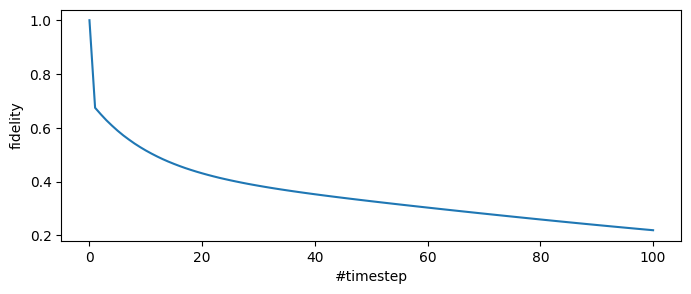

In [16]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,3))
ax.plot(fidelities_long)
ax.set_xlabel("#timestep")
ax.set_ylabel("fidelity")

### Try again with uniform reward weights

In [17]:
result_2 = optimize_pulse(
    U_0=rho_target,
    C_target=rho_target,
    system_params=system_params,
    num_time_steps=2,
    reward_weights = [1,1],
    mode="nn",
    goal="fidelity",
    max_iter=1000,
    convergence_threshold=1e-6,
    learning_rate=0.01,
    evo_type="density",
    batch_size=16,
    rnn=RNN,
    rnn_hidden_size=30,
)

In [18]:
from feedback_grape.fgrape import evaluate_on_longer_time

result_long_2 = evaluate_on_longer_time(
    U_0 = rho_target,
    C_target = rho_target,
    system_params = system_params,
    optimized_trainable_parameters = result_2.optimized_trainable_parameters,
    num_time_steps = 100,
    evo_type = "density",
    goal = "fidelity",
    mode = "nn",
    eval_batch_size=10,
    rnn=RNN,
    rnn_hidden_size=30,
)

fidelities_long_2 = result_long_2.fidelity_each_timestep

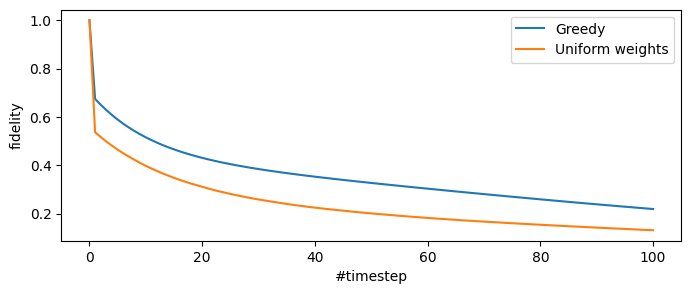

In [19]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,3))
ax.plot(fidelities_long, label="Greedy")
ax.plot(fidelities_long_2, label="Uniform weights")
ax.set_xlabel("#timestep")
ax.set_ylabel("fidelity")
ax.legend()
fig.savefig("example_E_fixed_evaluation.png")